# Statistical Analysis of Irrigation Values Inside and Outside Dam Command Areas (2000 & 2015)

This notebook performs descriptive statistics, visualizations, and hypothesis testing on irrigation pixel values extracted from inside and outside dam command areas for the years 2000 and 2015. The analysis follows advisor feedback and is structured as follows:

**Outline:**
1. Data Loading
2. Descriptive Statistics
3. Distribution Visualization
4. Statistical Hypothesis Testing

---

In [23]:
# Task 1: Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
from scipy.stats import mannwhitneyu, ttest_ind
import os
from rasterio.crs import CRS
from rasterio.mask import mask

import sys
from tqdm import tqdm
import warnings 
from IPython.display import display, Markdown
from itertools import product
warnings.filterwarnings('ignore')

# Add the project root to sys.path so we can import from Code.utils everywhere
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from Code.utils.utility import load_config, resolve_path, ssa_iso, africa_iso_countries, africa_iso_countries_filtered
from Code.utils.spatial_utility import load_raster_and_reproject, optimized_clip
import rasterio

# Load configuration
config = load_config()

# Load the four CSV files using resolve_path and config (for consistency with project I/O)
# Load irrigation data for years 1980, 1985, 1990, 1995, 2000, 2015 from .tiff files

years = [1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015]
irrigation_arrays = {}
for year in years:
    key = f'Irrigation_Arid_SSA_{year}_tif_path'
    path = resolve_path(config[key])
    with rasterio.open(path) as src:
        irrigation_arrays[year] = src.read(1)  # Read first band as numpy array


Data for year 1980 loaded from /home/waves/data/Africa_Irrigation/Data/Processed/Irrigation_Arid_SSA_1980.tif, sample rows: [[-9. -9. -9. ... -9. -9. -9.]
 [-9. -9. -9. ... -9. -9. -9.]
 [-9. -9. -9. ... -9. -9. -9.]]
Data for year 1985 loaded from /home/waves/data/Africa_Irrigation/Data/Processed/Irrigation_Arid_SSA_1985.tif, sample rows: [[-9. -9. -9. ... -9. -9. -9.]
 [-9. -9. -9. ... -9. -9. -9.]
 [-9. -9. -9. ... -9. -9. -9.]]
Data for year 1990 loaded from /home/waves/data/Africa_Irrigation/Data/Processed/Irrigation_Arid_SSA_1990.tif, sample rows: [[-9. -9. -9. ... -9. -9. -9.]
 [-9. -9. -9. ... -9. -9. -9.]
 [-9. -9. -9. ... -9. -9. -9.]]
Data for year 1995 loaded from /home/waves/data/Africa_Irrigation/Data/Processed/Irrigation_Arid_SSA_1995.tif, sample rows: [[-9. -9. -9. ... -9. -9. -9.]
 [-9. -9. -9. ... -9. -9. -9.]
 [-9. -9. -9. ... -9. -9. -9.]]
Data for year 2000 loaded from /home/waves/data/Africa_Irrigation/Data/Processed/Irrigation_Arid_SSA_2000.tif, sample rows: [[-9

In [42]:
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
from rasterio.io import MemoryFile
from rasterio.mask import mask
from IPython.display import display, Markdown

ca_path = resolve_path(config['No_Crop_Vectorized_CA_UniLayer_shp_path'])
ca_gdf = gpd.read_file(ca_path)
if ca_gdf.crs != "EPSG:4326":
    ca_gdf = ca_gdf.to_crs("EPSG:4326")

print("Command Area bounds:", ca_gdf.total_bounds)
print("Command Area CRS:", ca_gdf.crs)
print("Any invalid geometries:", (~ca_gdf.is_valid).sum())
print("Empty geometries:", ca_gdf.geometry.is_empty.sum())

results = []
inside_pixels_dict = {}
outside_pixels_dict = {}

for year in years:
    # Load and reproject raster to EPSG:4326
    raster_path = resolve_path(config[f'Irrigation_Arid_SSA_{year}_tif_path'])
    with rasterio.open(raster_path) as src_orig:
        print(f"Original raster {year} — CRS: {src_orig.crs}")
        print(f"Original raster bounds: {src_orig.bounds}")


    arr_reproj, transform, meta = load_raster_and_reproject(raster_path, target_crs="EPSG:4326")
    
     # 🔍 CHECK 2: Reprojected raster has values
    print(f"\n--- Year {year} ---")
    print("Unique values in arr_reproj:", np.unique(arr_reproj[~np.isnan(arr_reproj)]))

    meta.update({
        "height": arr_reproj.shape[0],
        "width": arr_reproj.shape[1],
        "transform": transform,
        "crs": "EPSG:4326",
        "count": 1,
        "dtype": arr_reproj.dtype
    })
    
    with MemoryFile() as memfile:
        with memfile.open(**meta) as src:
            src.write(arr_reproj, 1)
            
            # Mask inside command areas
            inside_mask, _ = mask(src, ca_gdf.geometry, crop=False, filled=True, nodata=src.nodata, invert=False)
            inside_pixels = inside_mask[0]
            inside_pixels = inside_pixels[(inside_pixels != src.nodata) & (inside_pixels != -9)]
            inside_pixels_dict[year] = inside_pixels

            # 🔍 CHECK 4: What is in the inside mask?
            print("Inside mask shape:", inside_mask.shape)
            print("Nonzero pixels inside:", inside_pixels.size)

            # Mask outside command areas (invert=True)
            outside_mask, _ = mask(src, ca_gdf.geometry, crop=False, filled=True, nodata=src.nodata, invert=True)
            outside_pixels = outside_mask[0]
            outside_pixels = outside_pixels[(outside_pixels != src.nodata) & (outside_pixels != -9)]
            outside_pixels_dict[year] = outside_pixels

            # Total irrigation value from original array
            all_valid_pixels = arr_reproj[(arr_reproj != src.nodata) & (arr_reproj != -9)]

            results.append({
                'Year': year,
                'Total Inside': np.nansum(inside_pixels),
                'Total Outside': np.nansum(outside_pixels),
                'Total (Check)': np.nansum(all_valid_pixels),
                'Inside + Outside == Total': np.isclose(
                    np.nansum(inside_pixels) + np.nansum(outside_pixels),
                    np.nansum(all_valid_pixels),
                    atol=1e-3
                )
            })

results_df = pd.DataFrame(results)
display(Markdown("### Fractional Pixel-Weighted Analysis Results"))
display(results_df)

Command Area bounds: [-16.5089688  -32.0369773   41.03782696  16.92830237]
Command Area CRS: EPSG:4326
Any invalid geometries: 0
Empty geometries: 0
Original raster 1980 — CRS: EPSG:4326
Original raster bounds: BoundingBox(left=-17.583333333333343, bottom=-34.83333333333333, right=51.41666666666666, top=27.333333333333336)

--- Year 1980 ---
Unique values in arr_reproj: [-9.000000e+00  0.000000e+00  4.380600e-02 ...  5.611096e+03  5.624150e+03
  5.679718e+03]
Inside mask shape: (1, 746, 828)
Nonzero pixels inside: 681
Original raster 1985 — CRS: EPSG:4326
Original raster bounds: BoundingBox(left=-17.583333333333343, bottom=-34.83333333333333, right=51.41666666666666, top=27.333333333333336)

--- Year 1985 ---
Unique values in arr_reproj: [-9.000000e+00  0.000000e+00  2.801500e-02 ...  5.881392e+03  5.886231e+03
  5.900111e+03]
Inside mask shape: (1, 746, 828)
Nonzero pixels inside: 681
Original raster 1990 — CRS: EPSG:4326
Original raster bounds: BoundingBox(left=-17.583333333333343, b

### Fractional Pixel-Weighted Analysis Results

,Year,Total Inside,Total Outside,Total (Check),Inside + Outside == Total
0,1980,174446.734375,3598293.50,3772740.75,True
1,1985,180216.343750,3861667.75,4041884.00,True
2,1990,187563.812500,4185576.25,4373140.00,True
3,1995,200012.062500,4580727.00,4780739.00,True
4,2000,223056.500000,4978802.50,5201859.50,True
5,2005,233686.312500,5006044.00,5239730.00,True
6,2010,237407.562500,5416411.00,5653819.00,True
7,2015,224764.500000,5534487.00,5759251.00,True


### Descriptive Statistics
For each group (inside/outside, per year), we calculate mean, median, standard deviation, variance, min, max, and quartiles. Variance is highlighted as a key metric.

In [ ]:
# Descriptive statistics for inside and outside pixels, per year
def descriptive_stats(arr, label):
    arr = arr[~np.isnan(arr)]  # Remove NaNs if any
    stats = {
        'Mean': np.mean(arr),
        'Median': np.median(arr),
        'Std Dev': np.std(arr),
        'Variance': np.var(arr),
        'Min': np.min(arr),
        'Q1 (25th)': np.percentile(arr, 25),
        'Q3 (75th)': np.percentile(arr, 75),
        'Max': np.max(arr)
    }
    print(f'--- Descriptive Statistics for {label} ---')
    for k, v in stats.items():
        if k == 'Variance':
            print(f'{k}: {v:.4f}  <--')
        else:
            print(f'{k}: {v:.4f}')
    print()

for year in years:
    inside_pixels = inside_pixels_dict[year]
    outside_pixels = outside_pixels_dict[year]

    descriptive_stats(inside_pixels, f'Inside Pixels {year}')
    descriptive_stats(outside_pixels, f'Outside Pixels {year}')


--- Descriptive Statistics for Inside Pixels 1980 ---
Mean: 256.1626
Median: 0.0000
Std Dev: 626.7901
Variance: 392865.8438  <--
Min: 0.0000
Q1 (25th): 0.0000
Q3 (75th): 122.8827
Max: 5325.6641

--- Descriptive Statistics for Outside Pixels 1980 ---
Mean: 19.4013
Median: 0.0000
Std Dev: 209.1736
Variance: 43753.5781  <--
Min: 0.0000
Q1 (25th): 0.0000
Q3 (75th): 0.0000
Max: 5679.7178

--- Descriptive Statistics for Inside Pixels 1985 ---
Mean: 264.6349
Median: 0.0000
Std Dev: 646.8760
Variance: 418448.5000  <--
Min: 0.0000
Q1 (25th): 0.0000
Q3 (75th): 133.1424
Max: 5591.0049

--- Descriptive Statistics for Outside Pixels 1985 ---
Mean: 20.8213
Median: 0.0000
Std Dev: 219.4225
Variance: 48146.2461  <--
Min: 0.0000
Q1 (25th): 0.0000
Q3 (75th): 0.0000
Max: 5900.1108

--- Descriptive Statistics for Inside Pixels 1990 ---
Mean: 275.4241
Median: 0.0000
Std Dev: 680.3500
Variance: 462876.0625  <--
Min: 0.0000
Q1 (25th): 0.0000
Q3 (75th): 137.8326
Max: 5700.5020

--- Descriptive Statistics for 

### Distribution Visualization
Plot histograms and KDEs for inside and outside groups for each year. Both distributions are shown on the same axes for direct comparison.

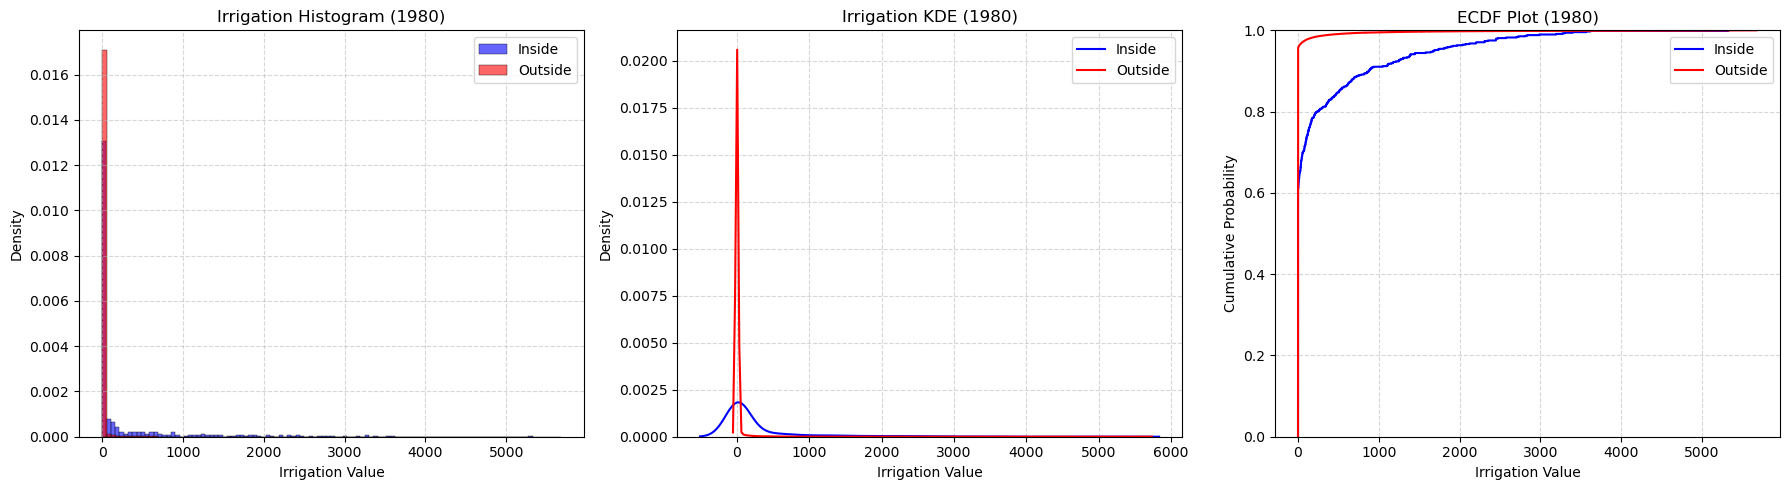

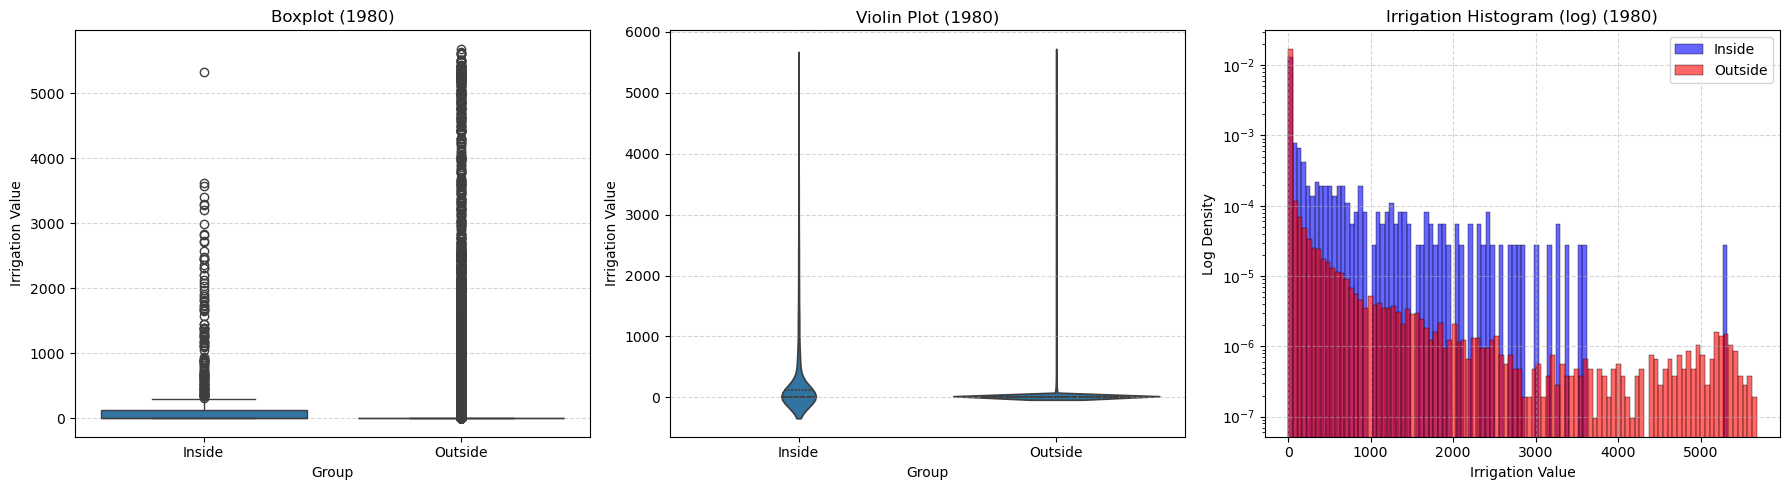

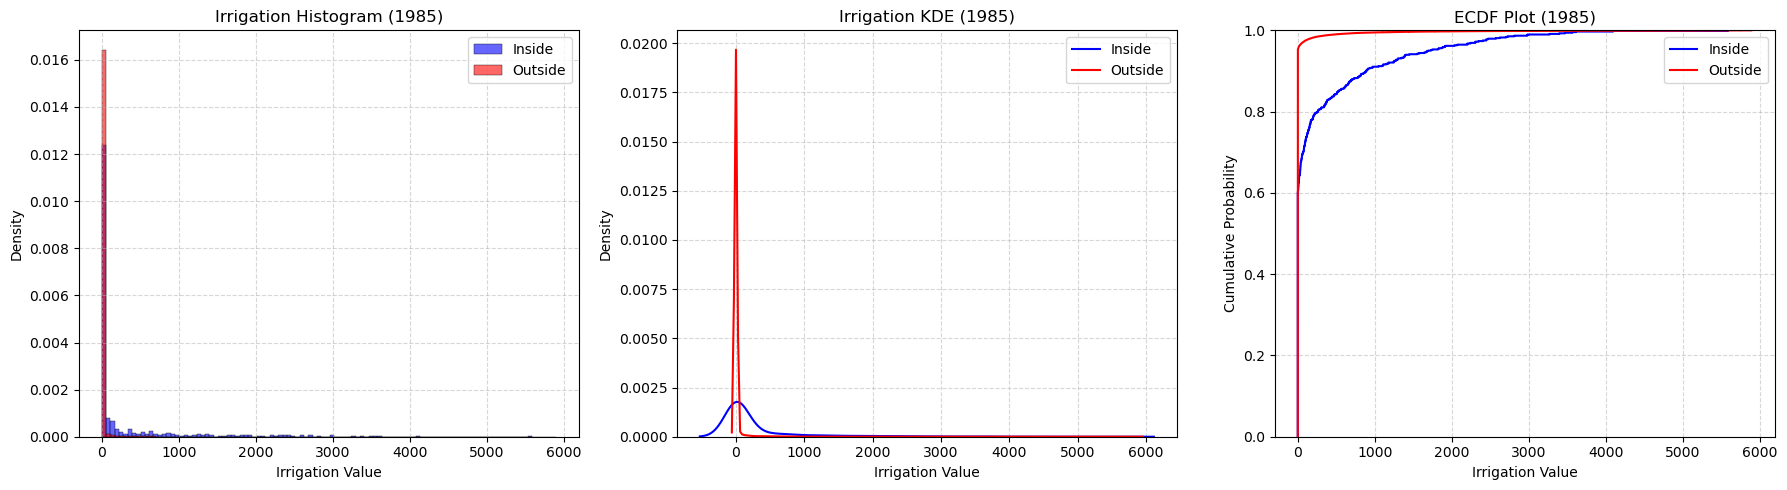

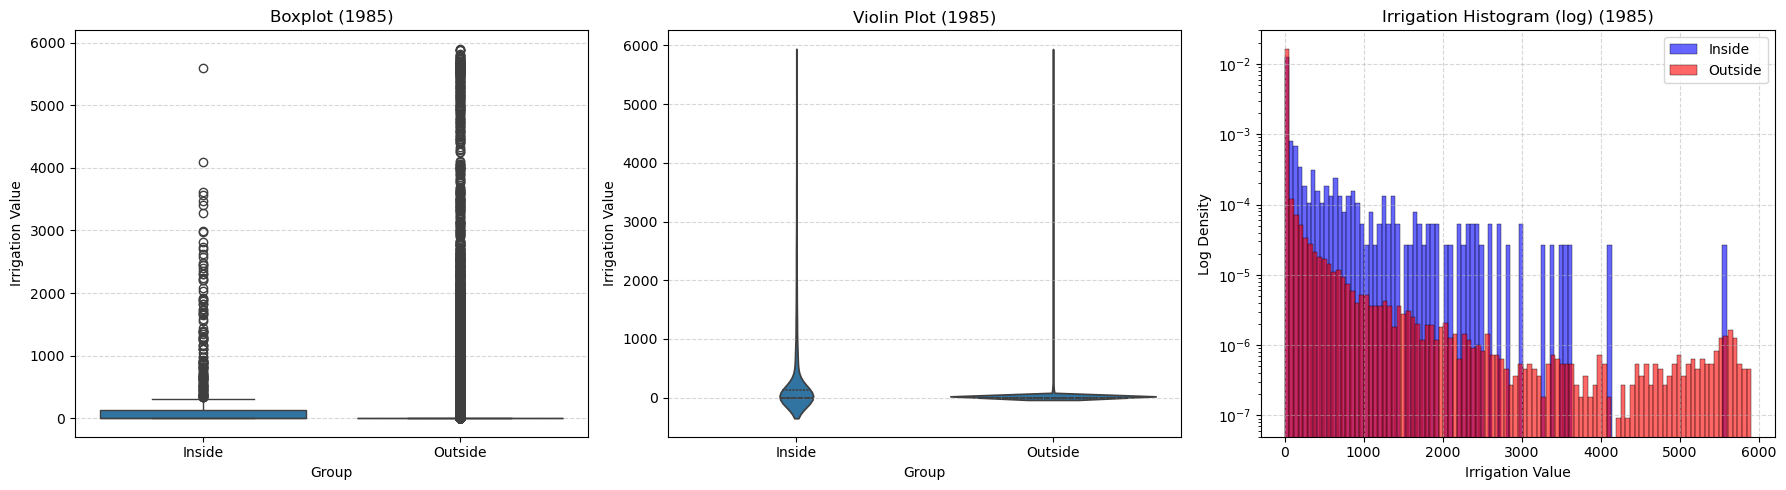

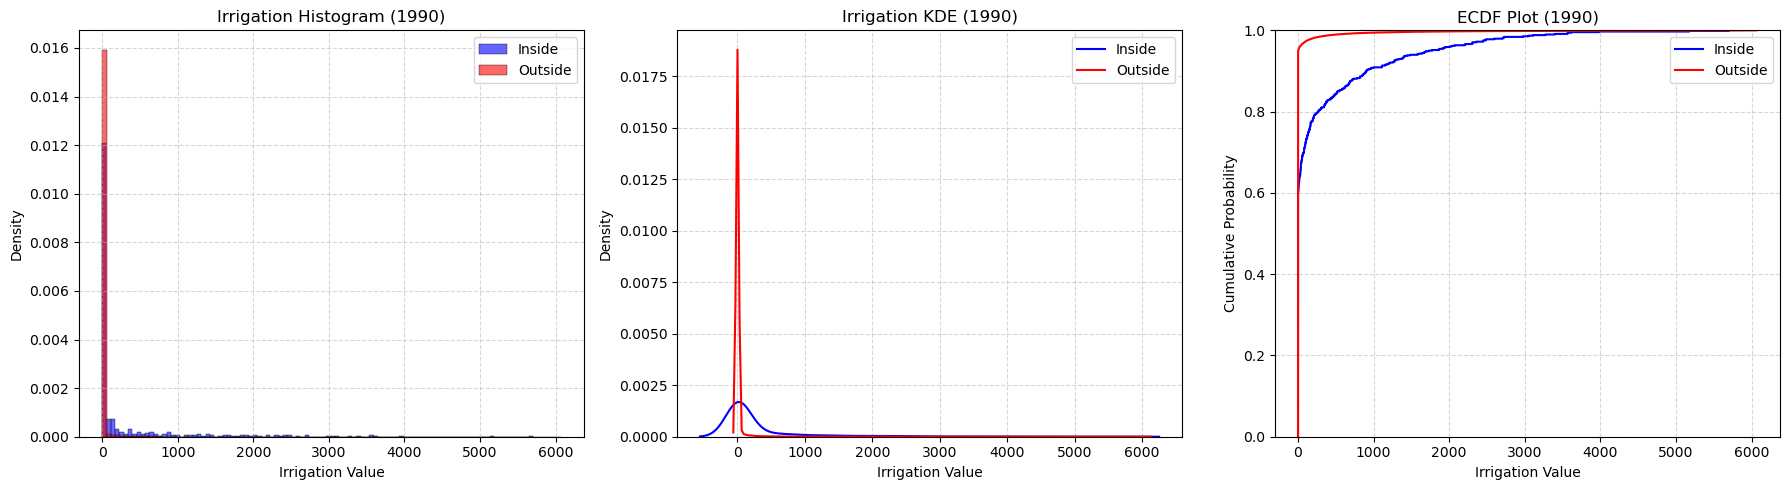

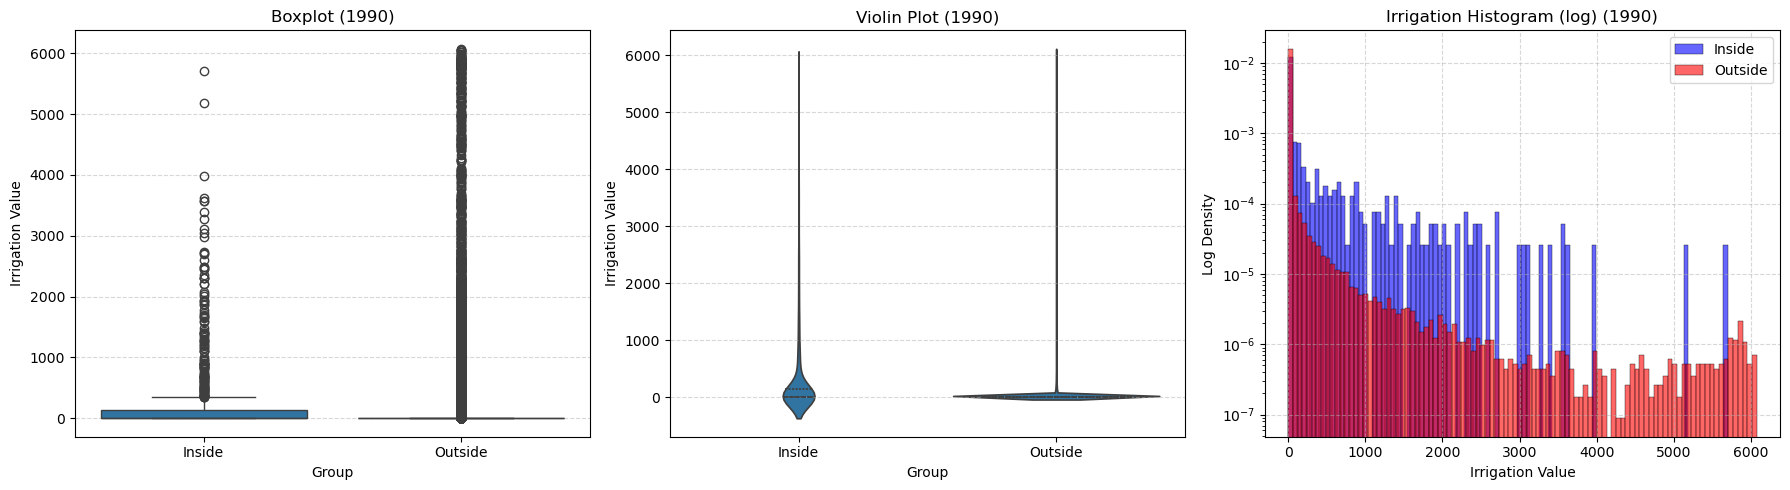

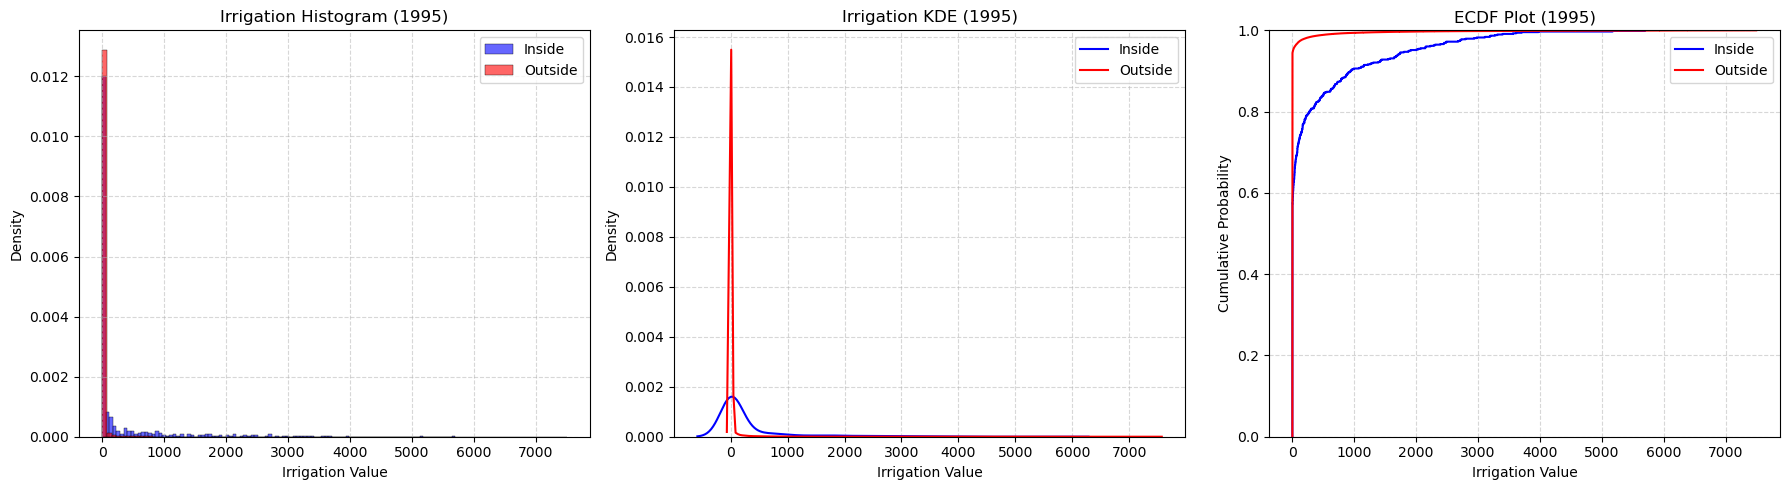

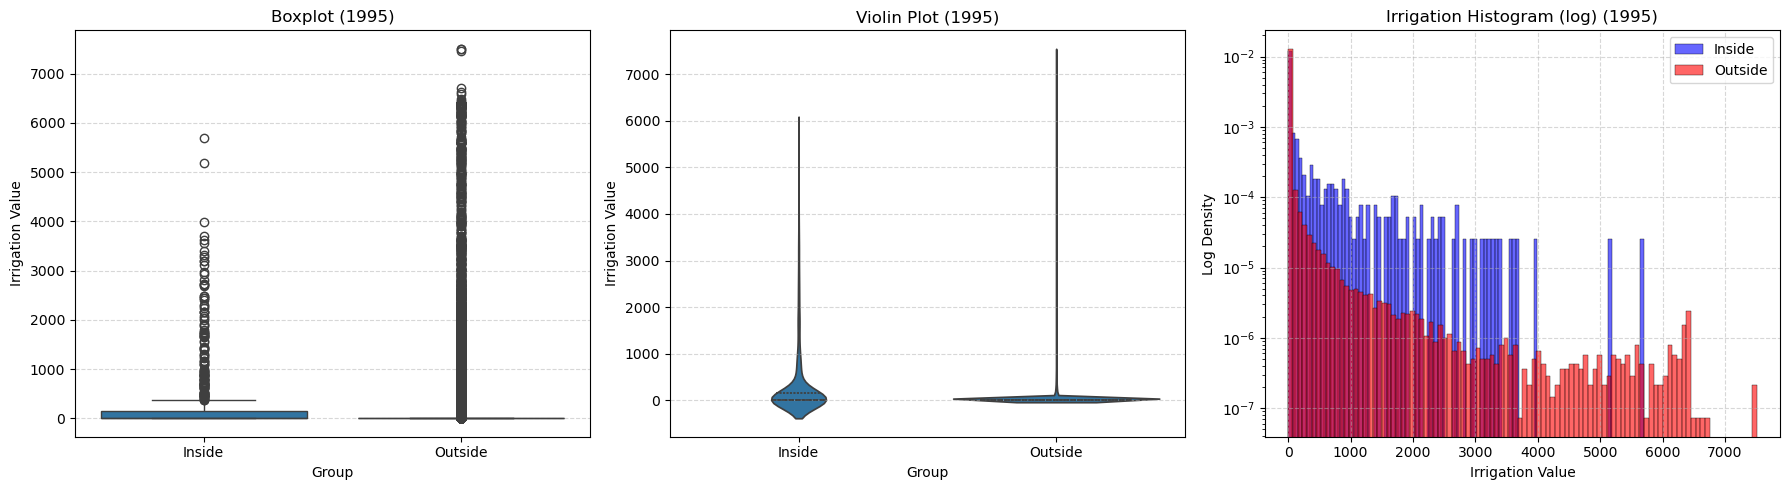

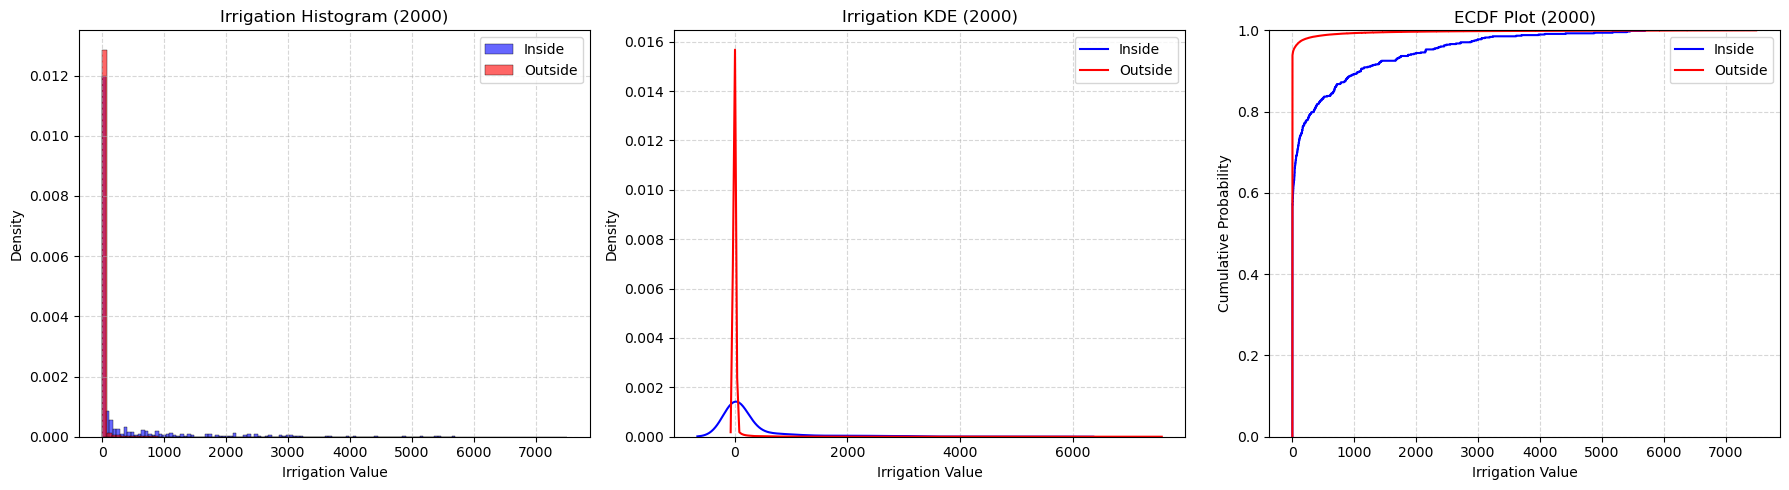

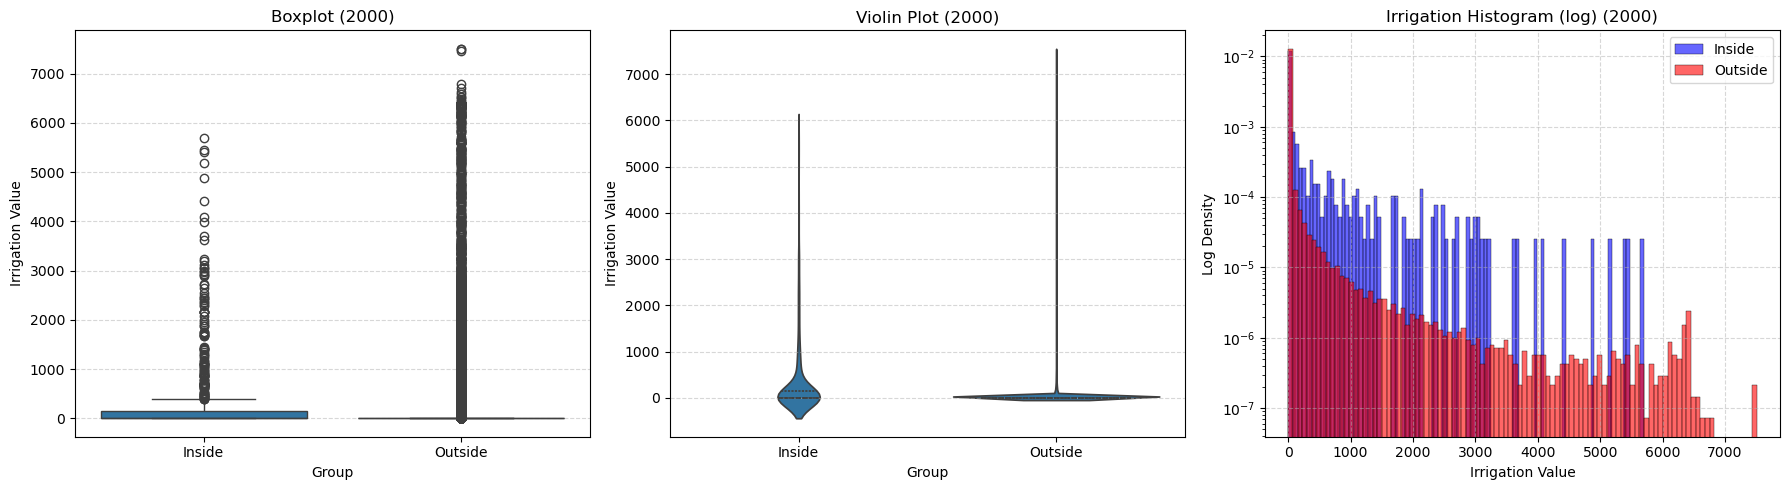

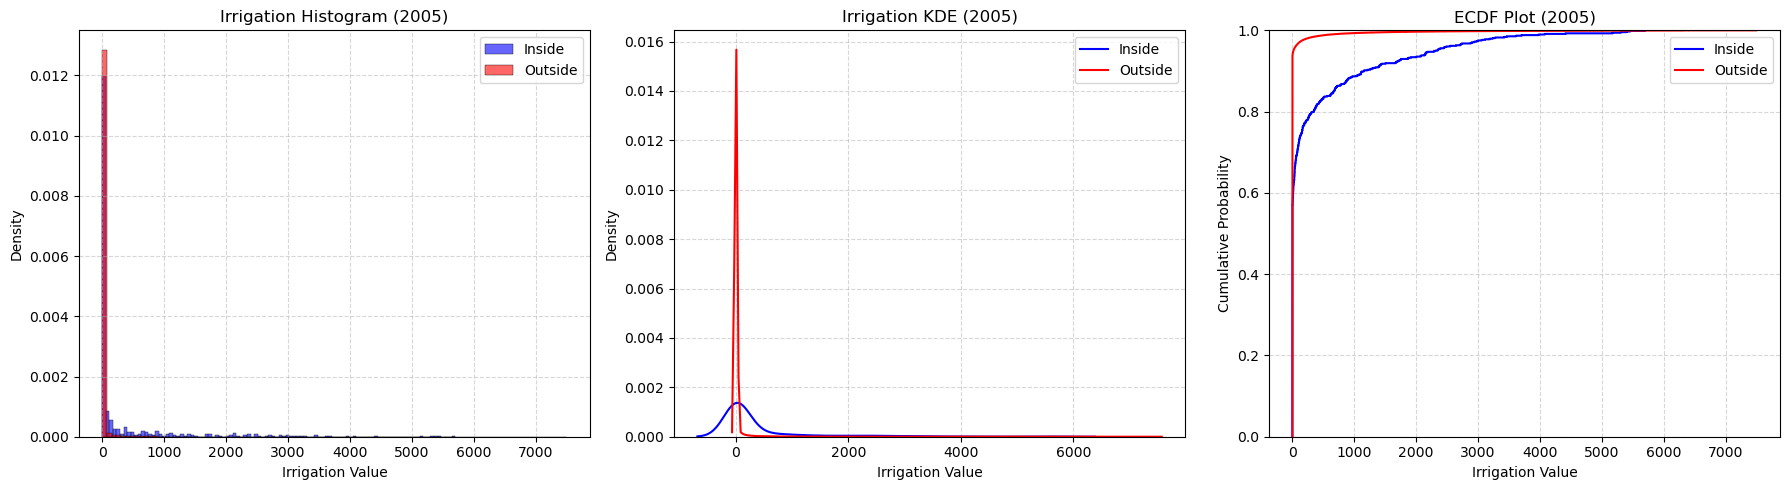

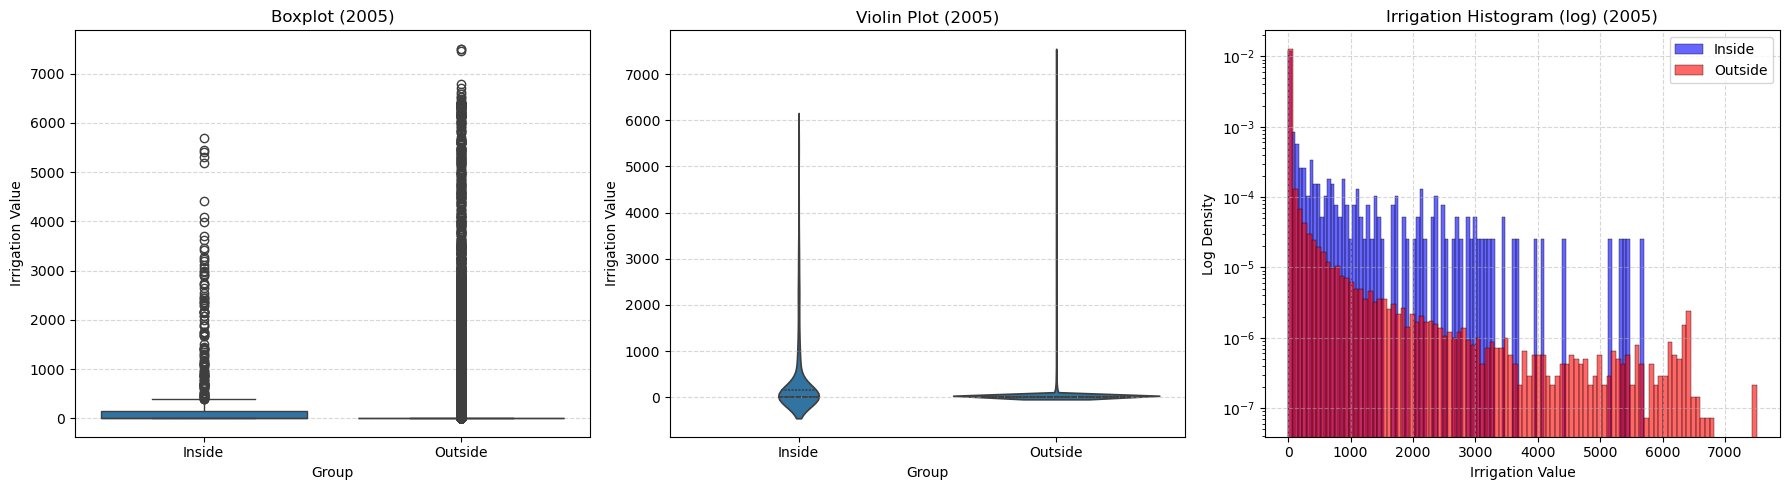

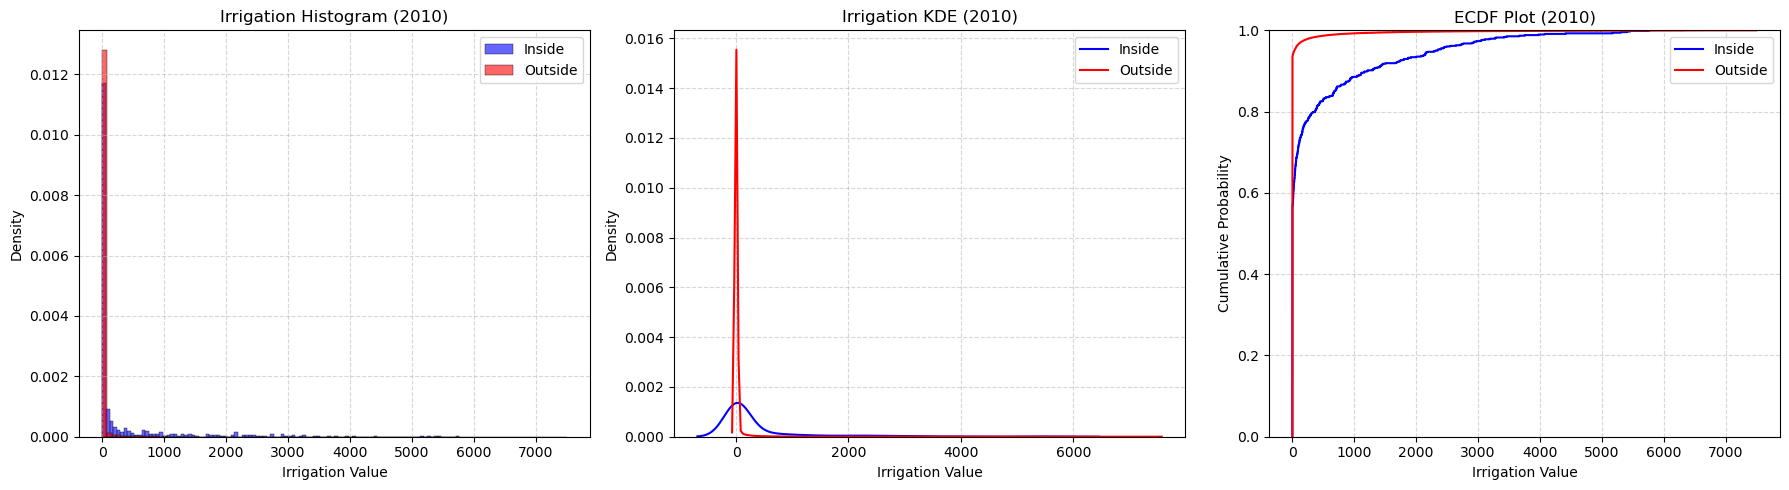

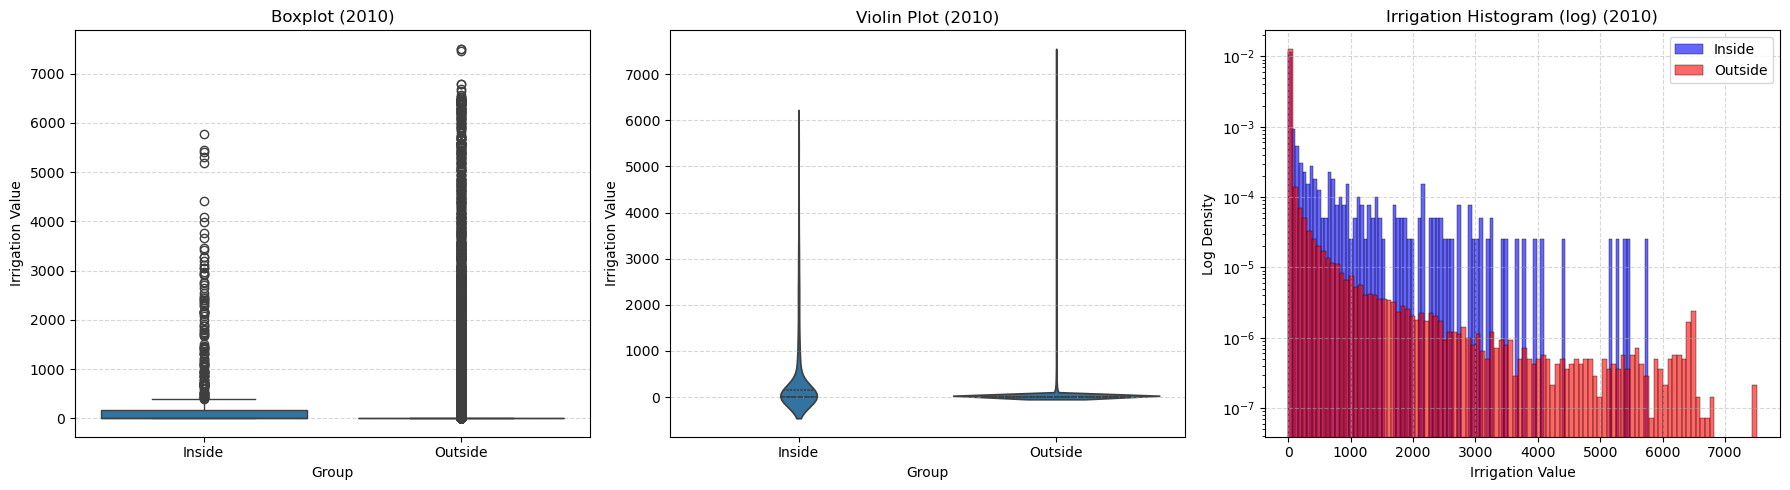

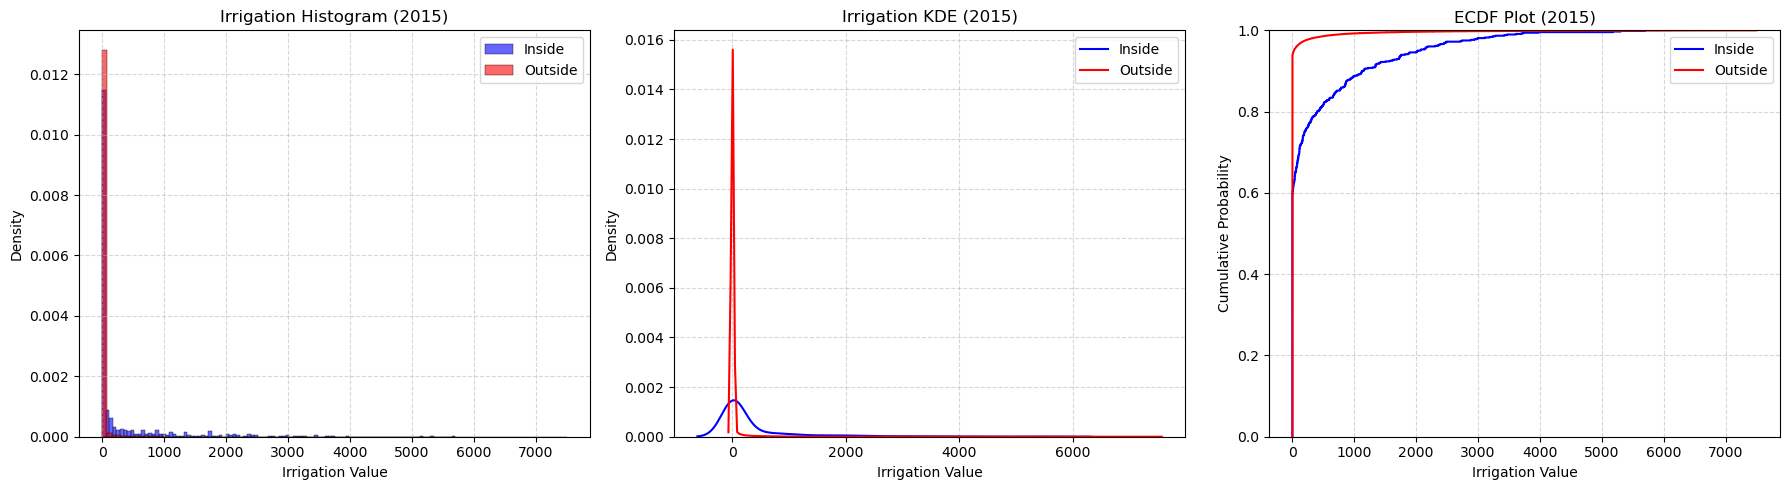

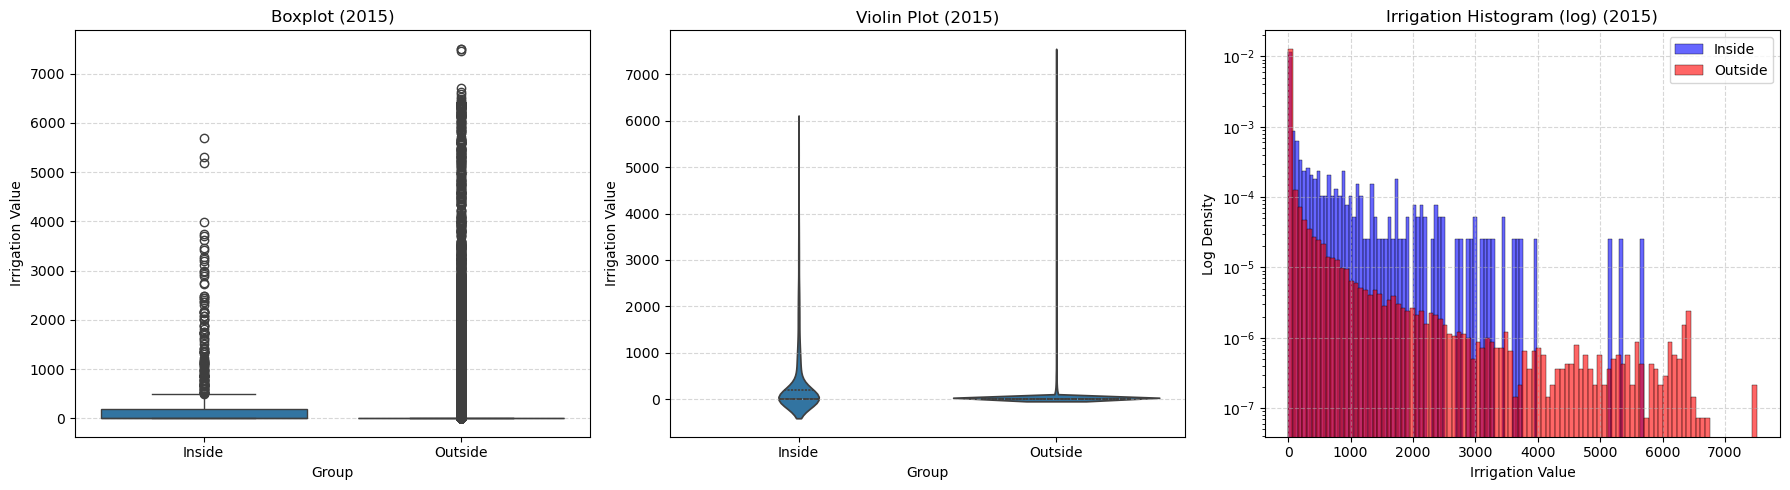

In [40]:
# For each year, plot two figures with 3 subplots each:
# Figure 1: Histogram, KDE, ECDF
# Figure 2: Boxplot, Violin plot, Log-scaled Histogram

for year in years:
    label = f"{year}"
    inside_df = to_df(inside_pixels_dict[year])
    outside_df = to_df(outside_pixels_dict[year])

    # Figure 1: Histogram, KDE, ECDF
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Histogram
    sns.histplot(inside_df['irrigation_value'], stat="density", bins=100, color='blue', label='Inside', alpha=0.6, ax=axes[0])
    sns.histplot(outside_df['irrigation_value'], stat="density", bins=100, color='red', label='Outside', alpha=0.6, ax=axes[0])
    axes[0].set_title(f'Irrigation Histogram ({label})')
    axes[0].set_xlabel("Irrigation Value")
    axes[0].set_ylabel("Density")
    axes[0].legend()
    axes[0].grid(True, linestyle="--", alpha=0.5)

    # KDE
    sns.kdeplot(inside_df['irrigation_value'], label='Inside', color='blue', ax=axes[1])
    sns.kdeplot(outside_df['irrigation_value'], label='Outside', color='red', ax=axes[1])
    axes[1].set_title(f'Irrigation KDE ({label})')
    axes[1].set_xlabel("Irrigation Value")
    axes[1].set_ylabel("Density")
    axes[1].legend()
    axes[1].grid(True, linestyle="--", alpha=0.5)

    # ECDF
    sns.ecdfplot(inside_df['irrigation_value'], label='Inside', color='blue', ax=axes[2])
    sns.ecdfplot(outside_df['irrigation_value'], label='Outside', color='red', ax=axes[2])
    axes[2].set_title(f'ECDF Plot ({label})')
    axes[2].set_xlabel("Irrigation Value")
    axes[2].set_ylabel("Cumulative Probability")
    axes[2].legend()
    axes[2].grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()

    # Figure 2: Boxplot, Violin plot, Log-scaled Histogram
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Boxplot
    combined_df = pd.concat([
        inside_df.assign(Group='Inside'),
        outside_df.assign(Group='Outside')
    ])
    sns.boxplot(data=combined_df, x='Group', y='irrigation_value', ax=axes[0])
    axes[0].set_title(f'Boxplot ({label})')
    axes[0].set_ylabel("Irrigation Value")
    axes[0].grid(True, axis='y', linestyle="--", alpha=0.5)

    # Violin plot
    sns.violinplot(data=combined_df, x='Group', y='irrigation_value', ax=axes[1], inner="quart")
    axes[1].set_title(f'Violin Plot ({label})')
    axes[1].set_ylabel("Irrigation Value")
    axes[1].grid(True, axis='y', linestyle="--", alpha=0.5)

    # Log-scaled Histogram
    sns.histplot(inside_df['irrigation_value'], stat="density", bins=100, color='blue', label='Inside', alpha=0.6, ax=axes[2])
    sns.histplot(outside_df['irrigation_value'], stat="density", bins=100, color='red', label='Outside', alpha=0.6, ax=axes[2])
    axes[2].set_title(f'Irrigation Histogram (log) ({label})')
    axes[2].set_xlabel("Irrigation Value")
    axes[2].set_ylabel("Log Density")
    axes[2].set_yscale("log")
    axes[2].legend()
    axes[2].grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()

### Statistical Hypothesis Testing
We use the Mann-Whitney U test to formally compare the distributions of irrigation values inside and outside polygons for each year.

**Null Hypothesis (H0):** The distributions of irrigation values inside and outside polygons are the same.

**Alternative Hypothesis (Ha):** The distributions are different.

In [ ]:
from scipy.stats import ttest_ind, mannwhitneyu
from itertools import product

# Cliff's Delta
def cliffs_delta(a, b):
    n1, n2 = len(a), len(b)
    greater = sum(x > y for x, y in product(a, b))
    less = sum(x < y for x, y in product(a, b))
    return (greater - less) / (n1 * n2)

# Statistical Test Summary
def run_tests_with_summary(df_in, df_out, label):
    a = df_in['irrigation_value']
    b = df_out['irrigation_value']

    mw_u, mw_p = mannwhitneyu(a, b, alternative='two-sided')
    t_stat, t_p = ttest_ind(a, b, equal_var=False)
    delta = cliffs_delta(a, b)
    conclusion = "Statistically significant" if mw_p < 0.05 or t_p < 0.05 else "No significant difference"
    
    print(f'--- {label} ---')
    print(f'Mann–Whitney U: U={mw_u:.2f}, p={mw_p:.4f}')
    print(f'T-test: t={t_stat:.2f}, p={t_p:.4f}')
    print(f"Cliff's delta: {delta:.4f}")
    print("Conclusion:", conclusion, "\n")

# Run tests for all years
for year in years:  # or use full `years` list
    label = f"{year}"
    df_in = to_df(inside_pixels_dict[year])
    df_out = to_df(outside_pixels_dict[year])
    run_tests_with_summary(df_in, df_out, label)

    # Optional: all pixels version (including zero irrigation)
    # label = f"{year} (All Pixels)"
    # df_in = to_df(inside_pixels_dict[year], nonzero_only=False)
    # df_out = to_df(outside_pixels_dict[year], nonzero_only=False)
    # run_tests_with_summary(df_in, df_out, label)


--- 1980 ---
Mann–Whitney U: U=85316377.50, p=0.0000
T-test: t=9.85, p=0.0000
Cliff's delta: 0.3510
Conclusion: Statistically significant 

--- 1985 ---
Mann–Whitney U: U=85669153.00, p=0.0000
T-test: t=9.83, p=0.0000
Cliff's delta: 0.3566
Conclusion: Statistically significant 

--- 1990 ---
Mann–Whitney U: U=85470107.00, p=0.0000
T-test: t=9.69, p=0.0000
Cliff's delta: 0.3534
Conclusion: Statistically significant 

--- 1995 ---
Mann–Whitney U: U=87148192.00, p=0.0000
T-test: t=9.79, p=0.0000
Cliff's delta: 0.3800
Conclusion: Statistically significant 

--- 2000 ---
Mann–Whitney U: U=87062450.50, p=0.0000
T-test: t=9.69, p=0.0000
Cliff's delta: 0.3786
Conclusion: Statistically significant 

--- 2005 ---
Mann–Whitney U: U=87038325.00, p=0.0000
T-test: t=9.79, p=0.0000
Cliff's delta: 0.3782
Conclusion: Statistically significant 

--- 2010 ---
Mann–Whitney U: U=86961421.00, p=0.0000
T-test: t=9.85, p=0.0000
Cliff's delta: 0.3770
Conclusion: Statistically significant 

--- 2015 ---
Mann–Wh

### Summary Visualizations
This section summarizes irrigation values by year and group using boxplots, violin plots, ECDFs, and stacked bar charts. These visualizations help compare the distribution and total volume of irrigation inside and outside dam command areas across all years.

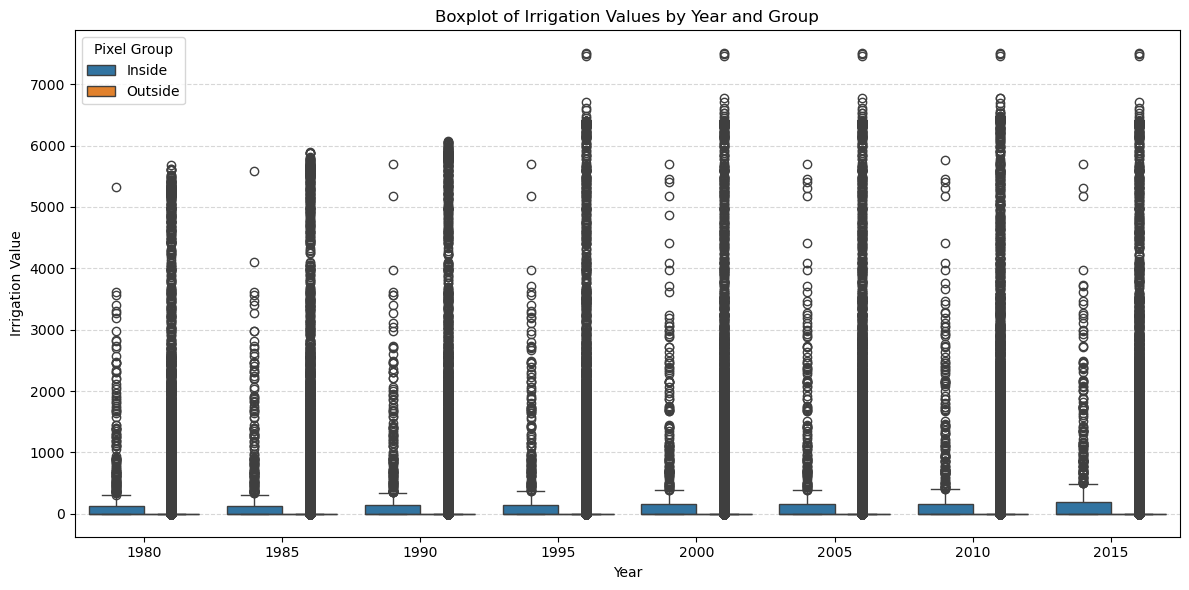

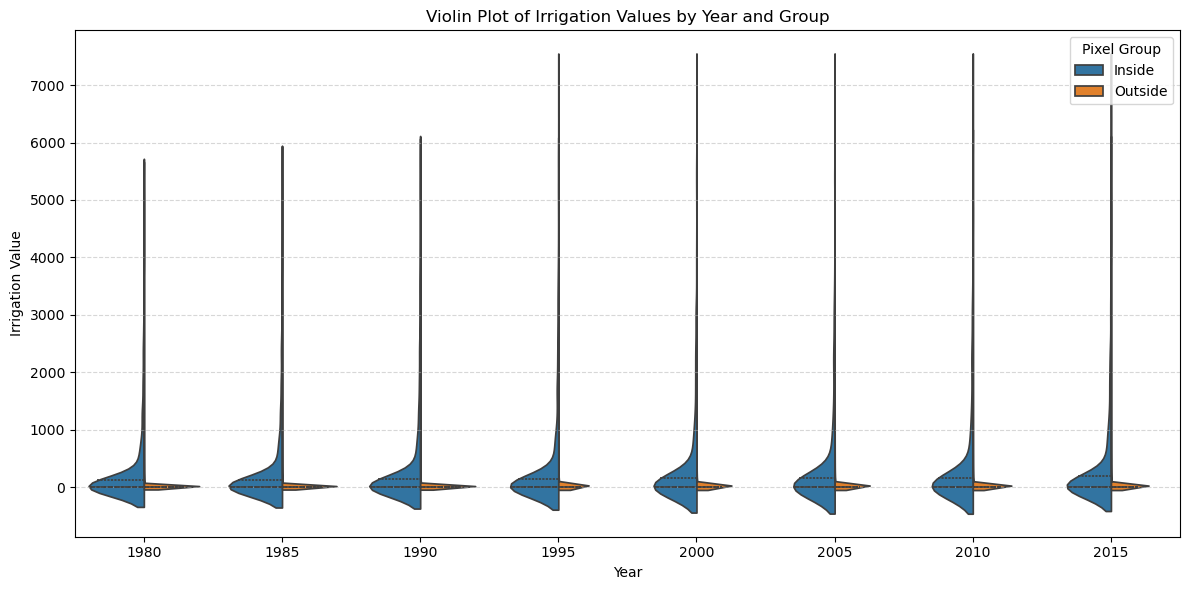

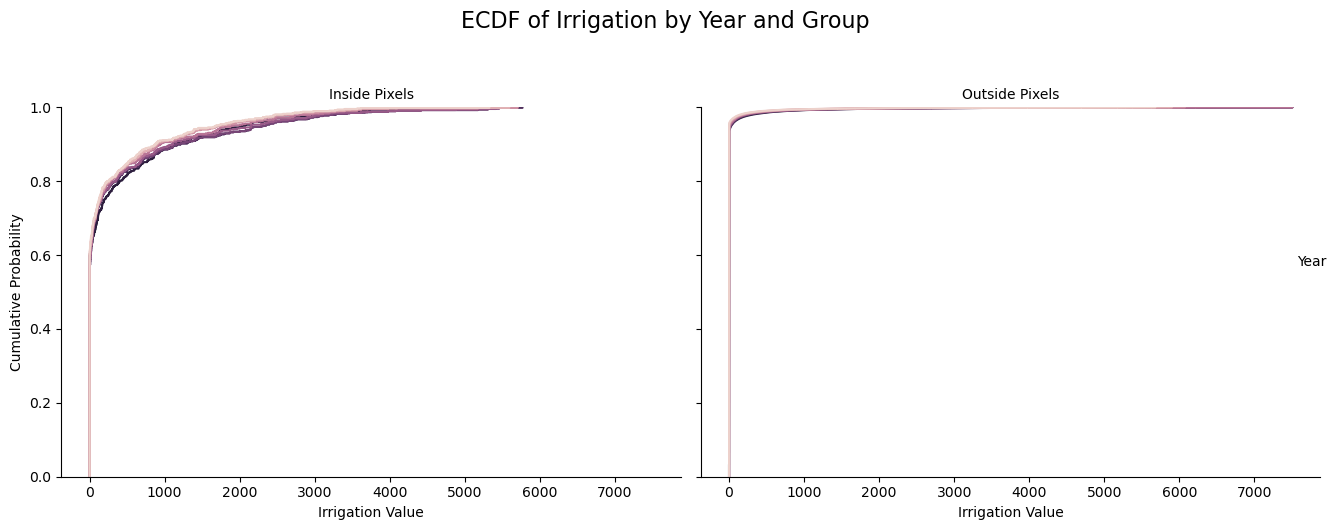

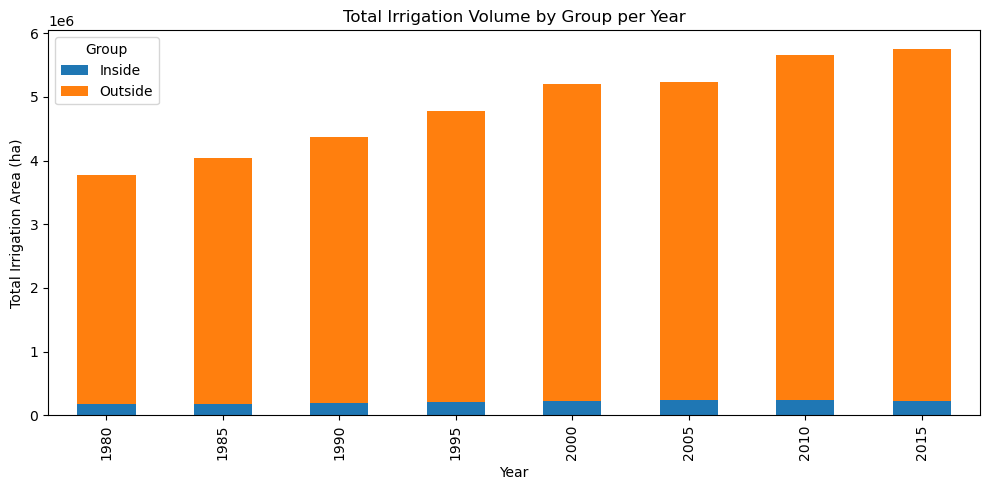

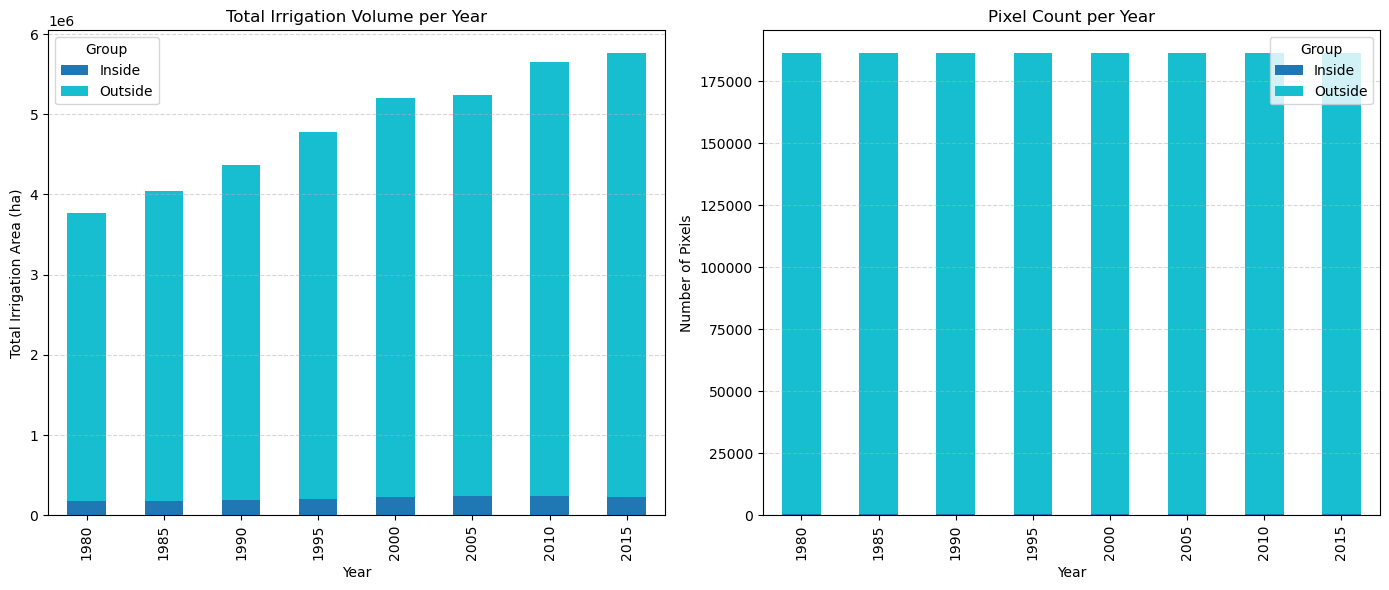

In [ ]:
# Build a long-form DataFrame containing all irrigation pixel values, grouped by year and location (Inside/Outside)
records = []
for year in years:
    for val in inside_pixels_dict[year]:
        if not np.isnan(val):
            records.append({'Year': year, 'Group': 'Inside', 'Irrigation': val})
    for val in outside_pixels_dict[year]:
        if not np.isnan(val):
            records.append({'Year': year, 'Group': 'Outside', 'Irrigation': val})

df_all = pd.DataFrame(records)

# Boxplot: Compare irrigation distributions by year and group
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_all, x='Year', y='Irrigation', hue='Group')
plt.title("Boxplot of Irrigation Values by Year and Group")
plt.ylabel("Irrigation Value")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.legend(title="Pixel Group")
plt.tight_layout()
plt.show()

# Violin plot: Show distribution shape and quartiles
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_all, x='Year', y='Irrigation', hue='Group', split=True, inner="quart")
plt.title("Violin Plot of Irrigation Values by Year and Group")
plt.ylabel("Irrigation Value")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.legend(title="Pixel Group")
plt.tight_layout()
plt.show()

# ECDF: Cumulative distribution comparison for each group and year
g = sns.FacetGrid(df_all, col="Group", height=5, aspect=1.3, sharey=True)
g.map_dataframe(sns.ecdfplot, x="Irrigation", hue="Year")
g.set_axis_labels("Irrigation Value", "Cumulative Probability")
g.add_legend(title="Year")
g.set_titles("{col_name} Pixels")
plt.suptitle("ECDF of Irrigation by Year and Group", y=1.05, fontsize=16)
plt.tight_layout()
plt.show()

# Summarize total irrigation by group and year, and plot as stacked bar chart
summary_by_group = df_all.groupby(['Year', 'Group'])['Irrigation'].sum().reset_index()
pivoted = summary_by_group.pivot(index='Year', columns='Group', values='Irrigation')
pivoted['Total'] = pivoted['Inside'] + pivoted['Outside']
pivoted['% Inside'] = pivoted['Inside'] / pivoted['Total']

pivoted[['Inside', 'Outside']].plot(kind='bar', stacked=True, figsize=(10, 5))
plt.title("Total Irrigation Volume by Group per Year")
plt.ylabel("Total Irrigation Area (ha)")
plt.tight_layout()
plt.show()